In [11]:
import pandas as pd
import numpy as np
import statistics
from datetime import datetime
import datetime
import random
import itertools
from scipy.stats import norm
#import seaborn as sns
import math
import random
import sklearn
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

In [12]:
#Lauras path
#data= pd.read_csv(r'C:\Users\moreno.l.5\Procter and Gamble\Idigoras, Anne - Project\Shipments\total shipments.csv')
#Annes path
df= pd.read_csv(r'C:\Users\idigoras.a\OneDrive - Procter and Gamble\05. Trainings&Acces\FODS 3\Project\Shipments\shipments_2022_2023_2024_Fabric_Baby_Hair.csv')

df = df.drop(columns=['Category'])
df= df.rename(columns={'Day Date (Real)': 'Date'})
categories = df['Sub Sector'].unique()
#df = df[df['Sub Sector'] == 'FABRIC']
df.head()


,Sub Sector,Shipment MSU Internal,Date
0,HAIR,0.1122,2022-01-03 00:00:00
1,HAIR,0.0346,2022-01-04 00:00:00
2,HAIR,0.0064,2022-01-05 00:00:00
3,HAIR,0.0049,2022-01-07 00:00:00
4,HAIR,0.0028,2022-01-10 00:00:00


In [13]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

print(df)

     Sub Sector  Shipment MSU Internal       Date
0          HAIR                 0.1122 2022-01-03
1          HAIR                 0.0346 2022-01-04
2          HAIR                 0.0064 2022-01-05
3          HAIR                 0.0049 2022-01-07
4          HAIR                 0.0028 2022-01-10
...         ...                    ...        ...
4641       HAIR                 4.8828 2024-05-17
4642       HAIR                -0.0028 2024-05-20
4643       HAIR                 5.0665 2024-05-21
4644       HAIR                 2.2694 2024-05-22
4645       HAIR                 2.0969 2024-05-23

[4646 rows x 3 columns]


In [14]:

# Pivot the DataFrame
df = df.pivot_table(index='Date', columns='Sub Sector', values='Shipment MSU Internal', aggfunc='sum')
# Fill NaN values with 0
df= df.fillna(0)
print(df)


Sub Sector     BABY   FABRIC     HAIR
Date                                 
2022-01-03  10.1881  12.5983  12.2046
2022-01-04   2.5806   6.8322   3.6671
2022-01-05   3.8445   9.9248   2.4512
2022-01-06   0.0071   0.0000   0.0000
2022-01-07   5.5063   9.5818   6.1986
...             ...      ...      ...
2024-05-17   7.9130   6.9862   6.9411
2024-05-20   0.7509   0.0000  -0.0065
2024-05-21   2.6287   9.2402   8.0431
2024-05-22   6.8281   1.1295   3.1925
2024-05-23   1.8003   3.4271   2.9701

[697 rows x 3 columns]


In [15]:
df = df.resample('W').sum()

print(df)


Sub Sector     BABY   FABRIC     HAIR
Date                                 
2022-01-09  22.9573  41.0606  24.5215
2022-01-16  25.3695  31.5509  11.5940
2022-01-23  24.1727  42.6518  21.6314
2022-01-30  18.1986  31.6521  37.4259
2022-02-06  22.9444  29.4992  24.4354
...             ...      ...      ...
2024-04-28  16.5507  31.1470  19.1727
2024-05-05  16.4453  21.1381  14.7862
2024-05-12  19.2233  17.2099  19.2639
2024-05-19  20.7189  24.5351  20.3170
2024-05-26  12.0080  13.7968  14.1992

[125 rows x 3 columns]


In [16]:
df = df.reset_index()

16:00:32 - cmdstanpy - INFO - Chain [1] start processing
16:00:32 - cmdstanpy - INFO - Chain [1] done processing
16:00:32 - cmdstanpy - INFO - Chain [1] start processing
16:00:33 - cmdstanpy - INFO - Chain [1] done processing
16:00:33 - cmdstanpy - INFO - Chain [1] start processing
16:00:34 - cmdstanpy - INFO - Chain [1] done processing


               FABRIC       BABY       HAIR
2024-05-31  15.365676  14.733591  21.156558
2024-06-30  21.763235  15.064566  17.736502
2024-07-31  21.008068  22.268460  24.154329
2024-08-31  25.375861  12.655956  18.709238
2024-09-30  20.788786  15.214228  23.094258
2024-10-31  23.850916  15.489687  18.273381
2024-11-30  23.660889  19.699788  20.308414
2024-12-31  14.325572   9.151241  10.894636
2025-01-31  23.868227  15.783195  20.199272
2025-02-28  17.479641  16.220654  15.946167
2025-03-31  16.743558  14.411570  25.443643
2025-04-30  21.050315  11.923864  17.292497


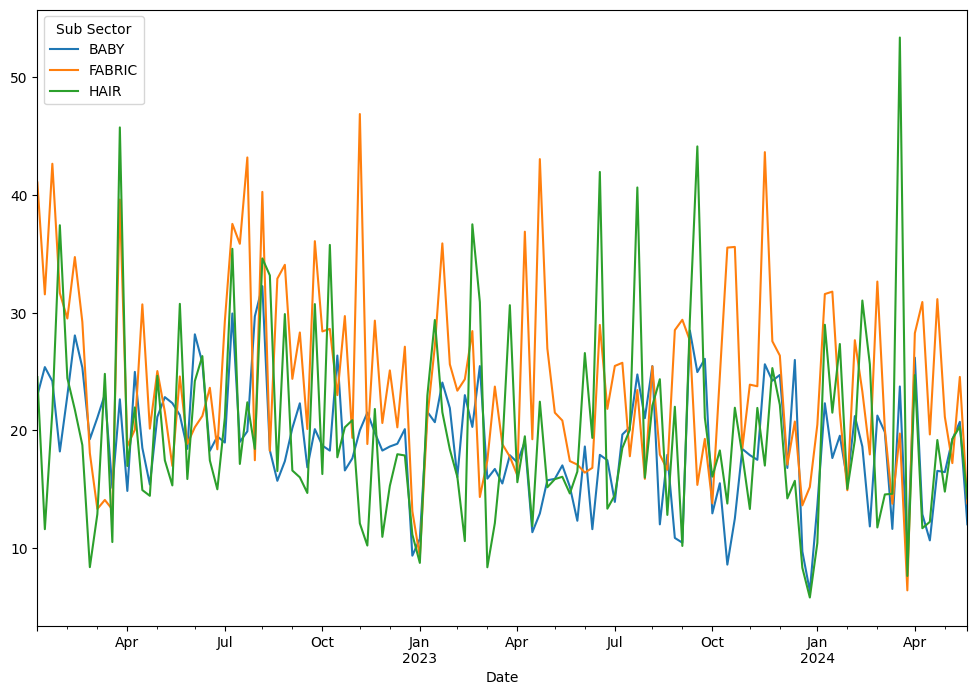

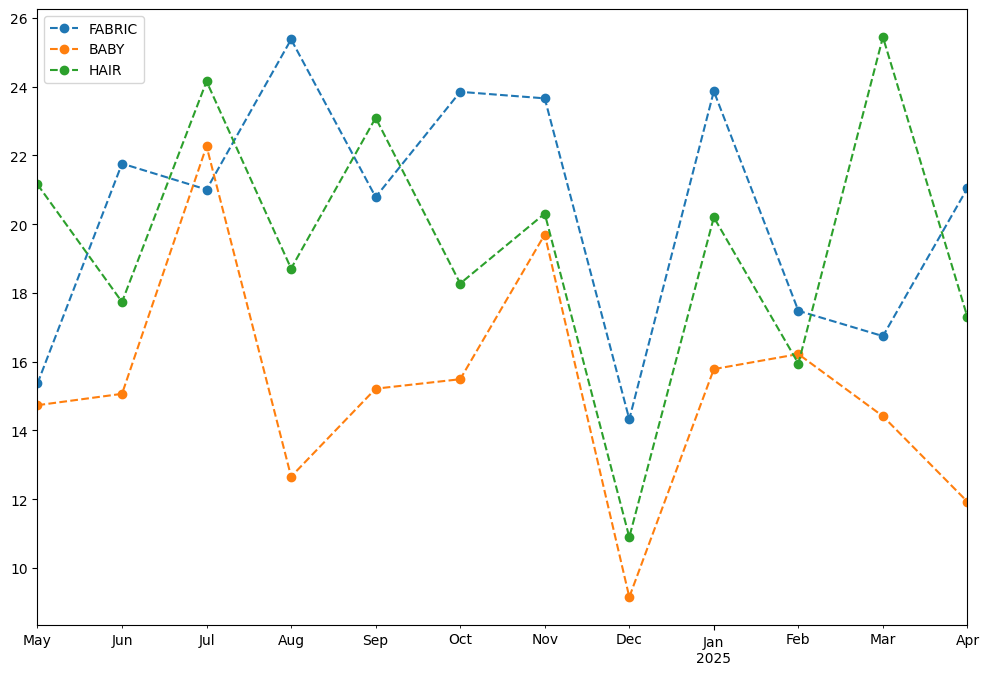

In [8]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Drop rows with missing values in the 'Date' column
df.dropna(subset=['Date'], inplace=True)

# Define the hierarchy based on the individual subgroups
hierarchy = {'FABRIC': ['FABRIC'], 'BABY': ['BABY'], 'HAIR': ['HAIR']}

# Prepare the data
y = df.set_index('Date')

# Perform hierarchical time series forecasting
forecast = pd.DataFrame()

for group, subgroups in hierarchy.items():
    group_data = y[subgroups].reset_index()
    group_data.columns = ['ds', 'y']
    
    model = Prophet()
    model.fit(group_data)
    
    future = model.make_future_dataframe(periods=12, freq='M')
    group_forecast = model.predict(future)
    
    forecast[group] = group_forecast['yhat'].tail(12)

# Set the index of the forecast DataFrame
last_date = y.index[-1]
forecast.index = pd.date_range(start=last_date, periods=12, freq='M')

print(forecast)

# Plot the historical data
y.plot(figsize=(12, 8))

# Plot the forecasts
forecast.plot(figsize=(12, 8), linestyle='--', marker='o')

plt.show()


17:54:59 - cmdstanpy - INFO - Chain [1] start processing
17:54:59 - cmdstanpy - INFO - Chain [1] done processing
17:54:59 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing


Average MAPE for FABRIC: 52.32%


17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing


Average MAPE for BABY: 25.04%


17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:06 - cmdstanpy - INFO - Chain [1] start processing
17:55:06 - cmdstanpy - INFO - Chain [1] done processing
17:55:06 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing
17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing


Average MAPE for HAIR: 32.86%


17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:09 - cmdstanpy - INFO - Chain [1] start processing
17:55:09 - cmdstanpy - INFO - Chain [1] done processing


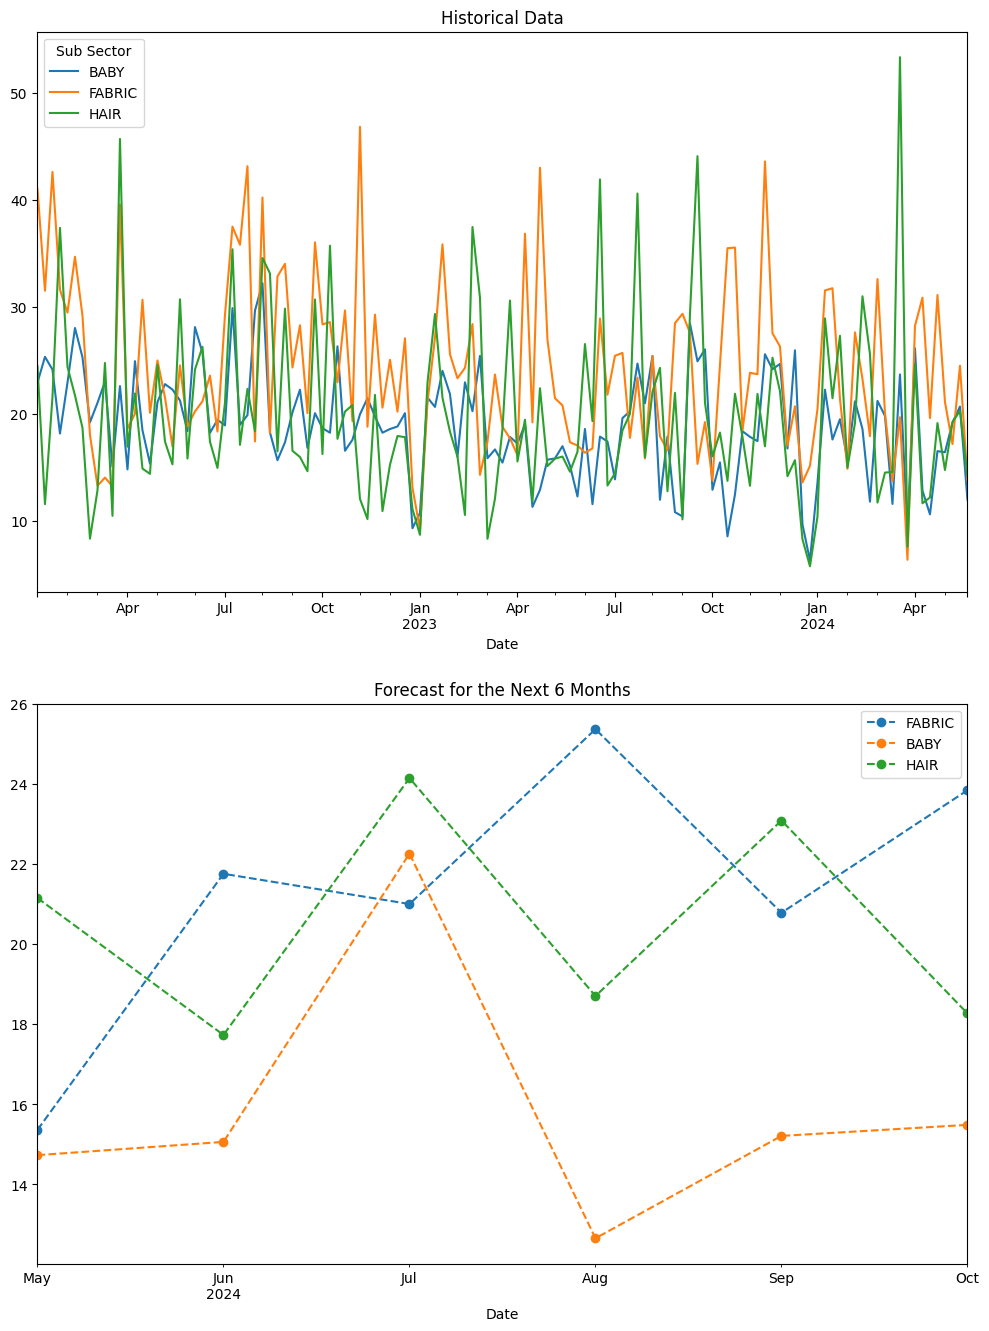

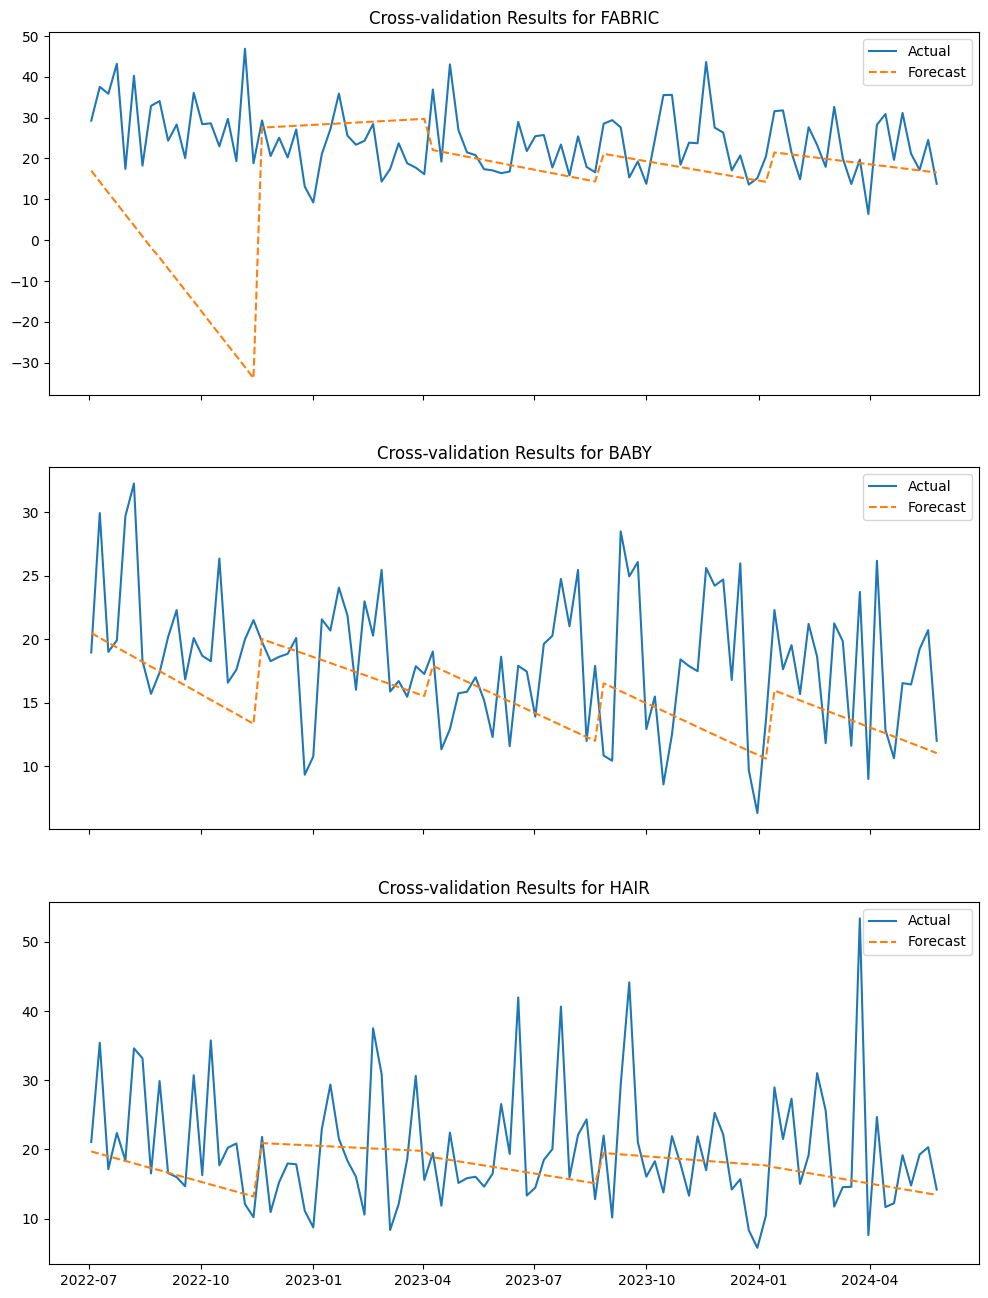

In [23]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Ensure 'Date' column is datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Drop rows with missing values in the 'Date' column
df.dropna(subset=['Date'], inplace=True)

# Define the hierarchy based on the individual subgroups
hierarchy = {'FABRIC': ['FABRIC'], 'BABY': ['BABY'], 'HAIR': ['HAIR']}

# Prepare the data
y = df.set_index('Date')

# Function to fit Prophet model and calculate MAPE for cross-validation
def fit_prophet_model(train_data, test_data):
    model = Prophet()
    model.fit(train_data)
    
    future = model.make_future_dataframe(periods=len(test_data), freq='M')
    forecast = model.predict(future)
    
    return forecast['yhat'].tail(len(test_data))

# Perform cross-validation and calculate MAPE
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed
mape_dict = {}
cv_results = {}

for group, subgroups in hierarchy.items():
    group_data = y[subgroups].reset_index()
    group_data.columns = ['ds', 'y']
    
    mape_scores = []
    all_test_data = pd.DataFrame()
    all_forecast_data = pd.DataFrame()

    for train_index, test_index in tscv.split(group_data):
        train_data, test_data = group_data.iloc[train_index], group_data.iloc[test_index]
        forecast_values = fit_prophet_model(train_data, test_data)
        
        actual = test_data['y']
        mape = mean_absolute_percentage_error(actual, forecast_values)
        mape_scores.append(mape)
        
        test_data = test_data.copy()
        test_data['yhat'] = forecast_values.values
        all_test_data = pd.concat([all_test_data, test_data])
        all_forecast_data = pd.concat([all_forecast_data, forecast_values])

    # Calculate average MAPE for the group
    mape_dict[group] = sum(mape_scores) / len(mape_scores)
    print(f"Average MAPE for {group}: {mape_dict[group]:.2%}")
    
    cv_results[group] = all_test_data

# Generate forecast for the next 6 months
forecast = pd.DataFrame()

for group, subgroups in hierarchy.items():
    group_data = y[subgroups].reset_index()
    group_data.columns = ['ds', 'y']
    
    model = Prophet()
    model.fit(group_data)
    
    future = model.make_future_dataframe(periods=6, freq='M')
    group_forecast = model.predict(future)
    
    forecast[group] = group_forecast.set_index('ds')['yhat'].tail(6)

# Set the index of the forecast DataFrame to datetime
forecast.index = pd.to_datetime(forecast.index)
forecast.index.name = 'Date'

# Plot the historical data
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

y.plot(ax=axes[0], title="Historical Data")
forecast.plot(ax=axes[1], linestyle='--', marker='o', title="Forecast for the Next 6 Months")

# Plot cross-validation results
fig, ax = plt.subplots(len(hierarchy), 1, figsize=(12, 16), sharex=True)

for i, (group, cv_data) in enumerate(cv_results.items()):
    ax[i].plot(cv_data['ds'], cv_data['y'], label='Actual')
    ax[i].plot(cv_data['ds'], cv_data['yhat'], label='Forecast', linestyle='--')
    ax[i].set_title(f'Cross-validation Results for {group}')
    ax[i].legend()

plt.show()





08:38:02 - cmdstanpy - INFO - Chain [1] start processing
08:38:03 - cmdstanpy - INFO - Chain [1] done processing
08:38:04 - cmdstanpy - INFO - Chain [1] start processing
08:38:04 - cmdstanpy - INFO - Chain [1] done processing
08:38:05 - cmdstanpy - INFO - Chain [1] start processing
08:38:07 - cmdstanpy - INFO - Chain [1] done processing
08:38:08 - cmdstanpy - INFO - Chain [1] start processing
08:38:09 - cmdstanpy - INFO - Chain [1] done processing
08:38:09 - cmdstanpy - INFO - Chain [1] start processing
08:38:10 - cmdstanpy - INFO - Chain [1] done processing
08:38:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:38:10 - cmdstanpy - INFO - Chain [1] start processing
08:38:10 - cmdstanpy - INFO - Chain [1] done processing
08:38:11 - cmdstanpy - INFO - Chain [1] start processing
08:38:11 - cmdstanpy - INFO - Chain [1] done processing
08:38:12 - cmdstanpy - INFO - Chain [1] start process

Best params for FABRIC: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}, MAPE: 47.44%


08:44:31 - cmdstanpy - INFO - Chain [1] start processing
08:44:32 - cmdstanpy - INFO - Chain [1] done processing
08:44:32 - cmdstanpy - INFO - Chain [1] start processing
08:44:33 - cmdstanpy - INFO - Chain [1] done processing
08:44:34 - cmdstanpy - INFO - Chain [1] start processing
08:44:34 - cmdstanpy - INFO - Chain [1] done processing
08:44:34 - cmdstanpy - INFO - Chain [1] start processing
08:44:35 - cmdstanpy - INFO - Chain [1] done processing
08:44:35 - cmdstanpy - INFO - Chain [1] start processing
08:44:36 - cmdstanpy - INFO - Chain [1] done processing
08:44:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:36 - cmdstanpy - INFO - Chain [1] start processing
08:44:36 - cmdstanpy - INFO - Chain [1] done processing
08:44:36 - cmdstanpy - INFO - Chain [1] start processing
08:44:37 - cmdstanpy - INFO - Chain [1] done processing
08:44:37 - cmdstanpy - INFO - Chain [1] start process

Best params for BABY: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}, MAPE: 24.93%


08:49:39 - cmdstanpy - INFO - Chain [1] start processing
08:49:40 - cmdstanpy - INFO - Chain [1] done processing
08:49:40 - cmdstanpy - INFO - Chain [1] start processing
08:49:41 - cmdstanpy - INFO - Chain [1] done processing
08:49:41 - cmdstanpy - INFO - Chain [1] start processing
08:49:42 - cmdstanpy - INFO - Chain [1] done processing
08:49:42 - cmdstanpy - INFO - Chain [1] start processing
08:49:43 - cmdstanpy - INFO - Chain [1] done processing
08:49:43 - cmdstanpy - INFO - Chain [1] start processing
08:49:44 - cmdstanpy - INFO - Chain [1] done processing
08:49:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:49:44 - cmdstanpy - INFO - Chain [1] start processing
08:49:44 - cmdstanpy - INFO - Chain [1] done processing
08:49:45 - cmdstanpy - INFO - Chain [1] start processing
08:49:45 - cmdstanpy - INFO - Chain [1] done processing
08:49:46 - cmdstanpy - INFO - Chain [1] start process

Best params for HAIR: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}, MAPE: 32.38%


08:53:37 - cmdstanpy - INFO - Chain [1] start processing
08:53:37 - cmdstanpy - INFO - Chain [1] done processing
08:53:38 - cmdstanpy - INFO - Chain [1] start processing
08:53:38 - cmdstanpy - INFO - Chain [1] done processing
08:53:38 - cmdstanpy - INFO - Chain [1] start processing
08:53:39 - cmdstanpy - INFO - Chain [1] done processing
08:53:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:53:39 - cmdstanpy - INFO - Chain [1] start processing
08:53:39 - cmdstanpy - INFO - Chain [1] done processing


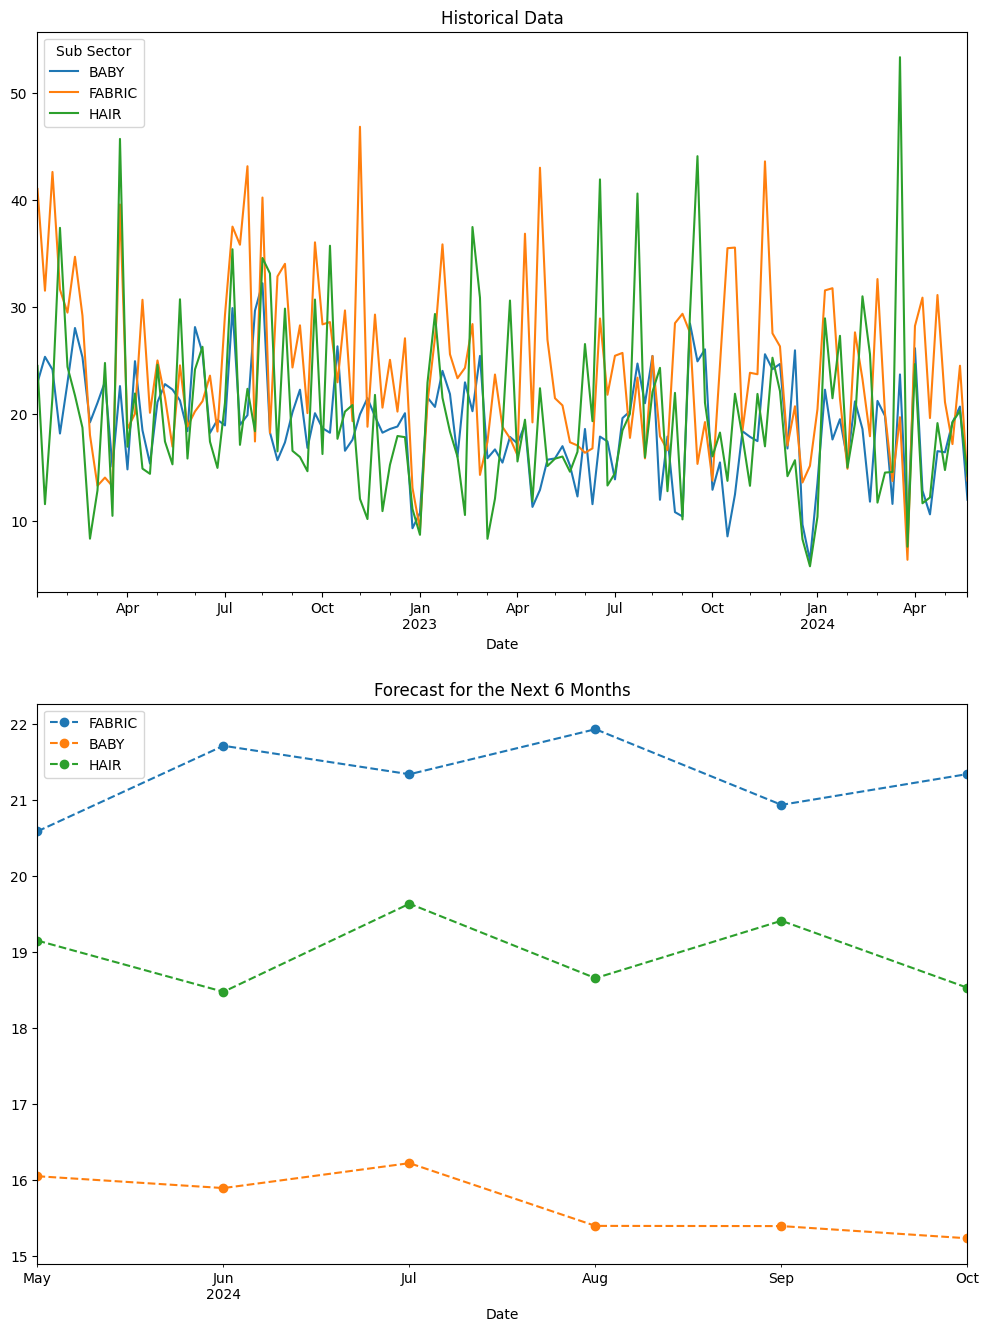

Final MAPE for FABRIC: 47.44%
Final MAPE for BABY: 24.93%
Final MAPE for HAIR: 32.38%


In [26]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is already defined and contains the necessary data
# Ensure 'Date' column is datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Drop rows with missing values in the 'Date' column
df.dropna(subset=['Date'], inplace=True)

# Define the hierarchy based on the individual subgroups
hierarchy = {'FABRIC': ['FABRIC'], 'BABY': ['BABY'], 'HAIR': ['HAIR']}

# Prepare the data
y = df.set_index('Date')

# Hyperparameter grid
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Function to fit Prophet model and calculate MAPE for cross-validation
def fit_prophet_model(train_data, test_data, params):
    model = Prophet(
        seasonality_mode=params['seasonality_mode'],
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        yearly_seasonality=True,
        weekly_seasonality=True
    )
    model.fit(train_data)
    
    future = model.make_future_dataframe(periods=len(test_data), freq='M')
    forecast = model.predict(future)
    
    return forecast['yhat'].tail(len(test_data))

# Perform cross-validation and hyperparameter optimization
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed
best_params = {}
best_mape = {}

for group, subgroups in hierarchy.items():
    group_data = y[subgroups].reset_index()
    group_data.columns = ['ds', 'y']
    
    best_group_params = None
    best_group_mape = float('inf')
    
    for seasonality_mode in param_grid['seasonality_mode']:
        for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
            for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
                params = {
                    'seasonality_mode': seasonality_mode,
                    'changepoint_prior_scale': changepoint_prior_scale,
                    'seasonality_prior_scale': seasonality_prior_scale
                }
                mape_scores = []

                for train_index, test_index in tscv.split(group_data):
                    train_data, test_data = group_data.iloc[train_index], group_data.iloc[test_index]
                    forecast_values = fit_prophet_model(train_data, test_data, params)

                    actual = test_data['y']
                    mape = mean_absolute_percentage_error(actual, forecast_values)
                    mape_scores.append(mape)

                avg_mape = np.mean(mape_scores)

                if avg_mape < best_group_mape:
                    best_group_mape = avg_mape
                    best_group_params = params
    
    best_params[group] = best_group_params
    best_mape[group] = best_group_mape
    print(f"Best params for {group}: {best_group_params}, MAPE: {best_group_mape:.2%}")

# Generate forecast for the next 6 months using best hyperparameters
forecast = pd.DataFrame()

for group, subgroups in hierarchy.items():
    group_data = y[subgroups].reset_index()
    group_data.columns = ['ds', 'y']
    
    best_group_params = best_params[group]
    
    model = Prophet(
        seasonality_mode=best_group_params['seasonality_mode'],
        changepoint_prior_scale=best_group_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_group_params['seasonality_prior_scale'],
        yearly_seasonality=True,
        weekly_seasonality=True
    )
    model.fit(group_data)
    
    future = model.make_future_dataframe(periods=6, freq='M')
    group_forecast = model.predict(future)
    
    forecast[group] = group_forecast.set_index('ds')['yhat'].tail(6)

# Set the index of the forecast DataFrame to datetime
forecast.index = pd.to_datetime(forecast.index)
forecast.index.name = 'Date'

# Plot the historical data and forecast
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

y.plot(ax=axes[0], title="Historical Data")
forecast.plot(ax=axes[1], linestyle='--', marker='o', title="Forecast for the Next 6 Months")

plt.show()

# Print the best MAPE values
for group, mape in best_mape.items():
    print(f"Final MAPE for {group}: {mape:.2%}")





09:12:15 - cmdstanpy - INFO - Chain [1] start processing
09:12:17 - cmdstanpy - INFO - Chain [1] done processing
09:12:17 - cmdstanpy - INFO - Chain [1] start processing
09:12:18 - cmdstanpy - INFO - Chain [1] done processing
09:12:18 - cmdstanpy - INFO - Chain [1] start processing
09:12:20 - cmdstanpy - INFO - Chain [1] done processing
09:12:20 - cmdstanpy - INFO - Chain [1] start processing
09:12:21 - cmdstanpy - INFO - Chain [1] done processing
09:12:21 - cmdstanpy - INFO - Chain [1] start processing
09:12:22 - cmdstanpy - INFO - Chain [1] done processing
09:12:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:12:22 - cmdstanpy - INFO - Chain [1] start processing
09:12:22 - cmdstanpy - INFO - Chain [1] done processing
09:12:23 - cmdstanpy - INFO - Chain [1] start processing
09:12:23 - cmdstanpy - INFO - Chain [1] done processing
09:12:24 - cmdstanpy - INFO - Chain [1] start process

Best params for FABRIC: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}, MAPE: 47.44%


09:18:01 - cmdstanpy - INFO - Chain [1] start processing
09:18:02 - cmdstanpy - INFO - Chain [1] done processing
09:18:02 - cmdstanpy - INFO - Chain [1] start processing
09:18:03 - cmdstanpy - INFO - Chain [1] done processing
09:18:03 - cmdstanpy - INFO - Chain [1] start processing
09:18:04 - cmdstanpy - INFO - Chain [1] done processing
09:18:04 - cmdstanpy - INFO - Chain [1] start processing
09:18:05 - cmdstanpy - INFO - Chain [1] done processing
09:18:05 - cmdstanpy - INFO - Chain [1] start processing
09:18:06 - cmdstanpy - INFO - Chain [1] done processing
09:18:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:18:06 - cmdstanpy - INFO - Chain [1] start processing
09:18:06 - cmdstanpy - INFO - Chain [1] done processing
09:18:06 - cmdstanpy - INFO - Chain [1] start processing
09:18:07 - cmdstanpy - INFO - Chain [1] done processing
09:18:07 - cmdstanpy - INFO - Chain [1] start process

Best params for BABY: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}, MAPE: 24.93%


09:22:19 - cmdstanpy - INFO - Chain [1] start processing
09:22:20 - cmdstanpy - INFO - Chain [1] done processing
09:22:20 - cmdstanpy - INFO - Chain [1] start processing
09:22:20 - cmdstanpy - INFO - Chain [1] done processing
09:22:21 - cmdstanpy - INFO - Chain [1] start processing
09:22:21 - cmdstanpy - INFO - Chain [1] done processing
09:22:22 - cmdstanpy - INFO - Chain [1] start processing
09:22:22 - cmdstanpy - INFO - Chain [1] done processing
09:22:22 - cmdstanpy - INFO - Chain [1] start processing
09:22:23 - cmdstanpy - INFO - Chain [1] done processing
09:22:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:22:23 - cmdstanpy - INFO - Chain [1] start processing
09:22:23 - cmdstanpy - INFO - Chain [1] done processing
09:22:24 - cmdstanpy - INFO - Chain [1] start processing
09:22:24 - cmdstanpy - INFO - Chain [1] done processing
09:22:25 - cmdstanpy - INFO - Chain [1] start process

Best params for HAIR: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}, MAPE: 32.38%


09:26:01 - cmdstanpy - INFO - Chain [1] start processing
09:26:01 - cmdstanpy - INFO - Chain [1] done processing
09:26:01 - cmdstanpy - INFO - Chain [1] start processing
09:26:02 - cmdstanpy - INFO - Chain [1] done processing
09:26:02 - cmdstanpy - INFO - Chain [1] start processing
09:26:02 - cmdstanpy - INFO - Chain [1] done processing
09:26:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:26:02 - cmdstanpy - INFO - Chain [1] start processing
09:26:03 - cmdstanpy - INFO - Chain [1] done processing


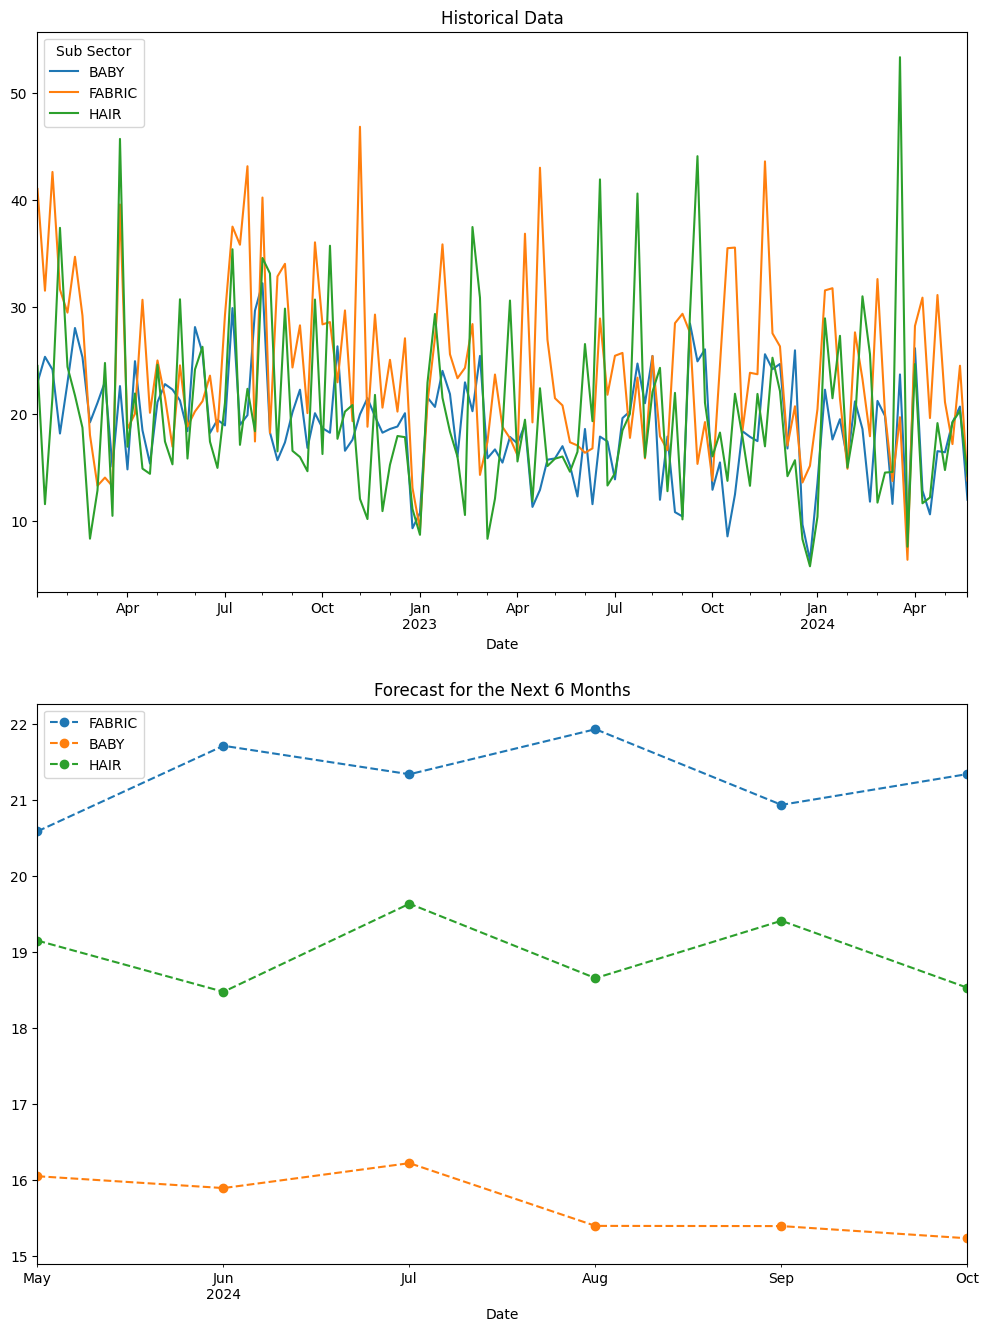

Final MAPE for FABRIC: 47.44%
Final MAPE for BABY: 24.93%
Final MAPE for HAIR: 32.38%


09:26:04 - cmdstanpy - INFO - Chain [1] start processing
09:26:04 - cmdstanpy - INFO - Chain [1] done processing
09:26:05 - cmdstanpy - INFO - Chain [1] start processing
09:26:05 - cmdstanpy - INFO - Chain [1] done processing
09:26:06 - cmdstanpy - INFO - Chain [1] start processing
09:26:06 - cmdstanpy - INFO - Chain [1] done processing
09:26:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:26:06 - cmdstanpy - INFO - Chain [1] start processing
09:26:07 - cmdstanpy - INFO - Chain [1] done processing


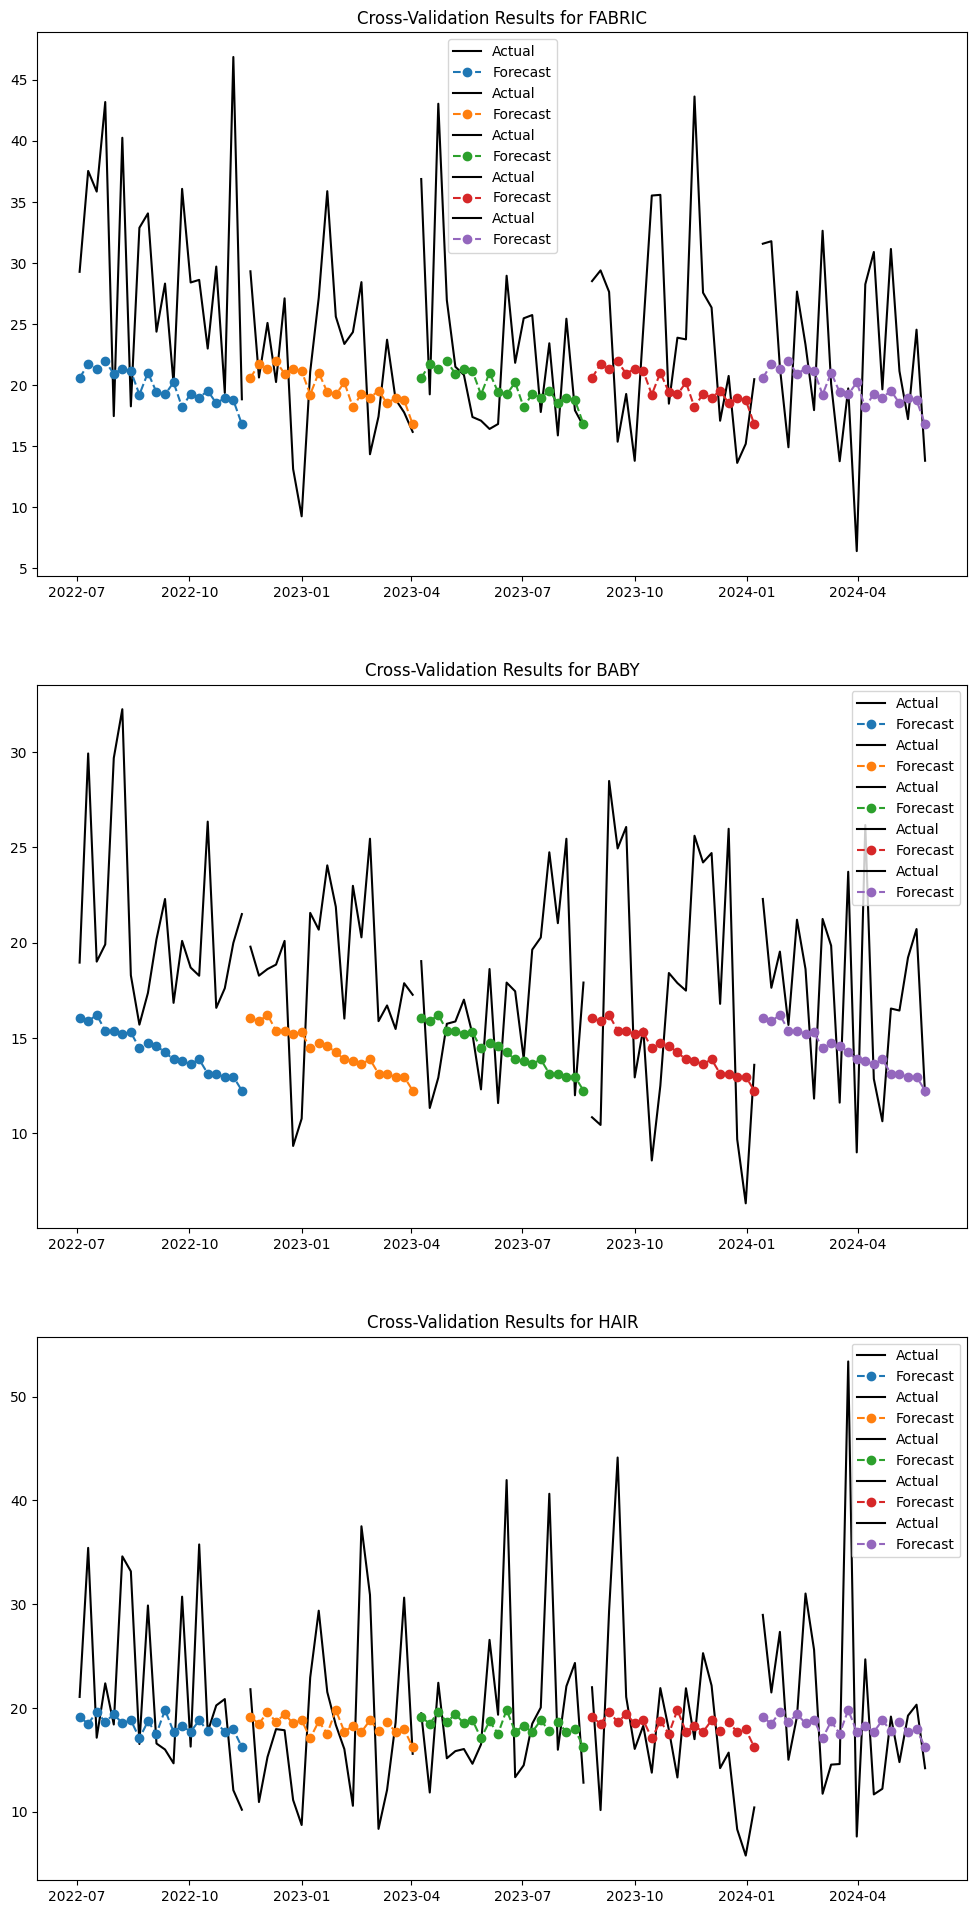

In [28]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'Date' column is datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Drop rows with missing values in the 'Date' column
df.dropna(subset=['Date'], inplace=True)

# Define the hierarchy based on the individual subgroups
hierarchy = {'FABRIC': ['FABRIC'], 'BABY': ['BABY'], 'HAIR': ['HAIR']}

# Prepare the data
y = df.set_index('Date')

# Hyperparameter grid
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Function to fit Prophet model and calculate MAPE for cross-validation
def fit_prophet_model(train_data, test_data, params):
    model = Prophet(
        seasonality_mode=params['seasonality_mode'],
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        yearly_seasonality=True,
        weekly_seasonality=True,
        uncertainty_samples=500  # Reduce number of uncertainty samples
    )
    model.fit(train_data)
    
    future = model.make_future_dataframe(periods=len(test_data), freq='M')
    forecast = model.predict(future)
    
    return forecast['yhat'].tail(len(test_data))

# Perform cross-validation and hyperparameter optimization
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed
best_params = {}
best_mape = {}

for group, subgroups in hierarchy.items():
    group_data = y[subgroups].reset_index()
    group_data.columns = ['ds', 'y']
    
    best_group_params = None
    best_group_mape = float('inf')
    
    for seasonality_mode in param_grid['seasonality_mode']:
        for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
            for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
                params = {
                    'seasonality_mode': seasonality_mode,
                    'changepoint_prior_scale': changepoint_prior_scale,
                    'seasonality_prior_scale': seasonality_prior_scale
                }
                mape_scores = []

                for train_index, test_index in tscv.split(group_data):
                    train_data, test_data = group_data.iloc[train_index], group_data.iloc[test_index]
                    forecast_values = fit_prophet_model(train_data, test_data, params)

                    actual = test_data['y']
                    mape = mean_absolute_percentage_error(actual, forecast_values)
                    mape_scores.append(mape)

                avg_mape = np.mean(mape_scores)

                if avg_mape < best_group_mape:
                    best_group_mape = avg_mape
                    best_group_params = params
    
    best_params[group] = best_group_params
    best_mape[group] = best_group_mape
    print(f"Best params for {group}: {best_group_params}, MAPE: {best_group_mape:.2%}")

# Generate forecast for the next 6 months using best hyperparameters
forecast = pd.DataFrame()

for group, subgroups in hierarchy.items():
    group_data = y[subgroups].reset_index()
    group_data.columns = ['ds', 'y']
    
    best_group_params = best_params[group]
    
    model = Prophet(
        seasonality_mode=best_group_params['seasonality_mode'],
        changepoint_prior_scale=best_group_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_group_params['seasonality_prior_scale'],
        yearly_seasonality=True,
        weekly_seasonality=True,
        uncertainty_samples=500  # Reduce number of uncertainty samples
    )
    model.fit(group_data)
    
    future = model.make_future_dataframe(periods=6, freq='M')
    group_forecast = model.predict(future)
    
    forecast[group] = group_forecast.set_index('ds')['yhat'].tail(6)

# Set the index of the forecast DataFrame to datetime
forecast.index = pd.to_datetime(forecast.index)
forecast.index.name = 'Date'

# Plot the historical data and forecast
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

y.plot(ax=axes[0], title="Historical Data")
forecast.plot(ax=axes[1], linestyle='--', marker='o', title="Forecast for the Next 6 Months")

plt.show()

# Print the best MAPE values
for group, mape in best_mape.items():
    print(f"Final MAPE for {group}: {mape:.2%}")

# Cross-validation for plotting the error distribution
cv_results = {}

for group, subgroups in hierarchy.items():
    group_data = y[subgroups].reset_index()
    group_data.columns = ['ds', 'y']
    
    best_group_params = best_params[group]
    
    model = Prophet(
        seasonality_mode=best_group_params['seasonality_mode'],
        changepoint_prior_scale=best_group_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_group_params['seasonality_prior_scale'],
        yearly_seasonality=True,
        weekly_seasonality=True,
        uncertainty_samples=500  # Reduce number of uncertainty samples
    )
    model.fit(group_data)
    
    # Perform cross-validation
    cv_results[group] = []

    for train_index, test_index in tscv.split(group_data):
        train_data, test_data = group_data.iloc[train_index], group_data.iloc[test_index]
        future = model.make_future_dataframe(periods=len(test_data), freq='M')
        forecast = model.predict(future)
        
        forecast_values = forecast['yhat'].tail(len(test_data))
        actual = test_data['y']
        
        cv_results[group].append((test_data['ds'], actual, forecast_values))

# Plot cross-validation results
fig, axes = plt.subplots(len(hierarchy), 1, figsize=(12, 8 * len(hierarchy)))

if len(hierarchy) == 1:
    axes = [axes]

for ax, (group, results) in zip(axes, cv_results.items()):
    for ds, actual, forecast_values in results:
        ax.plot(ds, actual, label='Actual', color='black')
        ax.plot(ds, forecast_values, label='Forecast', linestyle='--', marker='o')
    ax.set_title(f'Cross-Validation Results for {group}')
    ax.legend()

plt.show()

